In [84]:
import os
import numpy as np
import pandas as pd
import json
import tensorflow as tf
from datetime import datetime, timedelta

from dotenv import load_dotenv

from alpaca.data.requests import StockBarsRequest
from alpaca.data.historical.stock import StockHistoricalDataClient
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape

import matplotlib.pyplot as plt

In [85]:
# Load .env file

load_dotenv()

True

In [86]:
# Set Alpaca API key and secret

ALPACA_API_KEY = os.getenv("ALPACA_API_KEY")
ALPACA_SECRET_KEY = os.getenv("ALPACA_API_SECRET")
client = StockHistoricalDataClient(ALPACA_API_KEY, ALPACA_SECRET_KEY)

# Create the Alpaca API object

timeframe = TimeFrame(1, TimeFrameUnit.Day)
symbol = 'SPY'
start = datetime.utcnow() - timedelta(days=3650)
end=datetime.utcnow() - timedelta(days=5)
request = StockBarsRequest(symbol_or_symbols=symbol, start=start, end=end, timeframe=timeframe)

In [87]:
source_df = client.get_stock_bars(request).df.tz_convert('America/New_York', level=1)

In [88]:
display(source_df.head())
display(source_df.tail())

open    high     low     close  \
symbol timestamp                                                      
SPY    2016-01-04 00:00:00-05:00  200.490  201.03  198.59  201.0192   
       2016-01-05 00:00:00-05:00  201.405  201.90  200.05  201.3600   
       2016-01-06 00:00:00-05:00  198.330  200.06  197.60  198.8200   
       2016-01-07 00:00:00-05:00  195.330  197.44  193.59  194.0500   
       2016-01-08 00:00:00-05:00  195.190  195.85  191.58  191.9230   

                                       volume  trade_count        vwap  
symbol timestamp                                                        
SPY    2016-01-04 00:00:00-05:00  225903783.0     655489.0  200.656423  
       2016-01-05 00:00:00-05:00  112719152.0     418709.0  201.084280  
       2016-01-06 00:00:00-05:00  153948196.0     548386.0  198.956460  
       2016-01-07 00:00:00-05:00  216191953.0     796451.0  195.345911  
       2016-01-08 00:00:00-05:00  216105404.0     754102.0  193.644537

open    high      low   close  \
symbol timestamp                                                    
SPY    2024-02-12 00:00:00-05:00  501.17  503.50  500.240  500.98   
       2024-02-13 00:00:00-05:00  494.53  497.09  490.715  494.08   
       2024-02-14 00:00:00-05:00  496.79  499.07  494.400  498.57   
       2024-02-15 00:00:00-05:00  499.29  502.20  498.795  502.01   
       2024-02-16 00:00:00-05:00  501.70  502.87  498.750  499.51   

                                       volume  trade_count        vwap  
symbol timestamp                                                        
SPY    2024-02-12 00:00:00-05:00   56502283.0     437189.0  501.538780  
       2024-02-13 00:00:00-05:00  113099199.0     779480.0  494.284048  
       2024-02-14 00:00:00-05:00   68387827.0     536843.0  496.719466  
       2024-02-15 00:00:00-05:00   61682960.0     516093.0  500.763897  
       2024-02-16 00:00:00-05:00   75481032.0     531239.0  500.924740

In [89]:
bars_df = source_df.copy()
# pct_change is profit from last close
bars_df["pct_change"] = bars_df["close"].pct_change()
# signal for when we want to be in or out of a stock
#bars_df["signal"] = np.where(bars_df["pct_change"] > 0, 1.0, 0.0)
# reaction is the signal diff
#bars_df["reaction"] = bars_df["signal"].diff()
# action is if we could perfectly predict the next close
#bars_df["action"] = bars_df["reaction"].shift(-1)
# these values are the high, low, and open as a percentage of the current close
bars_df["high %"] = (bars_df["high"] - bars_df["close"])/bars_df["close"]
bars_df["low %"] = (bars_df["low"] - bars_df["close"])/bars_df["close"]
bars_df["open %"] = (bars_df["open"] - bars_df["close"])/bars_df["close"]

In [90]:
bars_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2045 entries, ('SPY', Timestamp('2016-01-04 00:00:00-0500', tz='America/New_York')) to ('SPY', Timestamp('2024-02-16 00:00:00-0500', tz='America/New_York'))
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         2045 non-null   float64
 1   high         2045 non-null   float64
 2   low          2045 non-null   float64
 3   close        2045 non-null   float64
 4   volume       2045 non-null   float64
 5   trade_count  2045 non-null   float64
 6   vwap         2045 non-null   float64
 7   pct_change   2044 non-null   float64
 8   high %       2045 non-null   float64
 9   low %        2045 non-null   float64
 10  open %       2045 non-null   float64
dtypes: float64(11)
memory usage: 262.5+ KB


In [91]:
# Cleanup DF for model

bars_df = bars_df.droplevel(level=0).dropna()
bars_df.head()

,open,high,low,close,volume,trade_count,vwap,pct_change,high %,low %,open %
timestamp,,,,,,,,,,,
2016-01-05 00:00:00-05:00,201.405,201.90,200.05,201.360,112719152.0,418709.0,201.084280,0.001695,0.002682,-0.006506,0.000223
2016-01-06 00:00:00-05:00,198.330,200.06,197.60,198.820,153948196.0,548386.0,198.956460,-0.012614,0.006237,-0.006136,-0.002465
2016-01-07 00:00:00-05:00,195.330,197.44,193.59,194.050,216191953.0,796451.0,195.345911,-0.023992,0.017470,-0.002371,0.006596
2016-01-08 00:00:00-05:00,195.190,195.85,191.58,191.923,216105404.0,754102.0,193.644537,-0.010961,0.020461,-0.001787,0.017022
2016-01-11 00:00:00-05:00,193.010,193.41,189.82,192.110,205368067.0,701548.0,191.757659,0.000974,0.006767,-0.011920,0.004685


In [92]:
# Normalize data set

scaler = StandardScaler()
bars_df_scaled = scaler.fit_transform(bars_df)


In [93]:
# Define constants

# input shape

input_shape = bars_df_scaled.shape[1]
latent_dim = 11
num_samples = bars_df_scaled.shape[0]
batch_size = 16


In [94]:
# Define generator (Sequential)

build_generator = Sequential([
    Dense(128,input_shape=(input_shape,), activation="relu"),
    Dense(256, activation="relu"),
    Dense(512, activation="relu"),
    Dense(input_shape, activation="sigmoid")
])

# Define descriminator

build_discriminator = Sequential([
    Dense(512, input_shape=(input_shape,), activation="relu"),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(1, activation="sigmoid")
])

In [95]:
# Compile generator
build_generator.compile(loss = "mse", optimizer="adam")

# Compile discriminator
build_discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [96]:
# Combine models

# Confirm that discriminator weights are not training during generators training

build_discriminator.trainable=False

# Setup for generators data

z = tf.keras.Input(shape=(latent_dim,))

# Generated data by the generator

generated_data = build_generator(z)

# Discriminators verdict

validity = build_discriminator(generated_data)

In [97]:
# Define combined models

combined = tf.keras.Model(z, validity)
combined.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

# Print summary of the combined model
combined.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 11)]              0         
                                                                 
 sequential_8 (Sequential)   (None, 11)                171787    
                                                                 
 sequential_9 (Sequential)   (None, 1)                 170497    
                                                                 
Total params: 342284 (1.31 MB)
Trainable params: 171787 (671.04 KB)
Non-trainable params: 170497 (666.00 KB)
_________________________________________________________________


In [98]:
# Define training loop

epochs = 10000

for epoch in range(epochs):
    # Train discriminator
    # Sample real data

    idx = np.random.choice(num_samples, batch_size, replace=False)
    real_data = bars_df_scaled[idx]

    # Generate fake data (Random Walk noise)

    gaussian_noise = np.random.normal(0,1,size=(batch_size,input_shape))
    random_walk_noise = np.cumsum(gaussian_noise, axis=0)

    fake_data = build_generator.predict(random_walk_noise)

    # Train discriminator

    d_loss_real = build_discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = build_discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Train generator 

    noise = np.random.normal(0, 1, (batch_size, input_shape))
    g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))
    
    # Print progress

    print(f"Epoch {epoch}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")


1/1 [==============================] - 0s 41ms/step


2024-02-24 20:59:20.681179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-24 20:59:20.825770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 0, Discriminator Loss: [0.71308249 0.4375    ], Generator Loss: [0.3578244149684906, 0.0]
1/1 [==============================] - 0s 11ms/step


2024-02-24 20:59:21.117520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1, Discriminator Loss: [1.00106761 0.75      ], Generator Loss: [0.4590602219104767, 0.0]
1/1 [==============================] - 0s 13ms/step
Epoch 2, Discriminator Loss: [0.53361303 0.8125    ], Generator Loss: [0.5482122898101807, 0.0]
1/1 [==============================] - 0s 14ms/step
Epoch 3, Discriminator Loss: [0.63365903 0.6875    ], Generator Loss: [0.585563600063324, 0.0]
1/1 [==============================] - 0s 13ms/step
Epoch 4, Discriminator Loss: [0.54787266 0.84375   ], Generator Loss: [0.6456398963928223, 0.0]
1/1 [==============================] - 0s 12ms/step
Epoch 5, Discriminator Loss: [0.61375478 0.75      ], Generator Loss: [0.6856558322906494, 0.0]
1/1 [==============================] - 0s 12ms/step
Epoch 6, Discriminator Loss: [0.48659859 0.78125   ], Generator Loss: [0.728296160697937, 0.0]
1/1 [==============================] - 0s 12ms/step
Epoch 7, Discriminator Loss: [0.38219434 0.84375   ], Generator Loss: [0.735848069190979, 0.0]
1/1 [==============

In [99]:
# Saving Model Weights

build_generator.save("generator_model.h5")
build_discriminator.save("discriminator_model.h5")

/Users/ebrown/anaconda3/envs/GAN_kernel/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [100]:
# Create alpaca object for testing

timeframe = TimeFrame(1, TimeFrameUnit.Day)
symbol = 'AAPL'
start = datetime.utcnow() - timedelta(days=730)
end=datetime.utcnow() - timedelta(days=1)
request = StockBarsRequest(symbol_or_symbols=symbol, start=start, end=end, timeframe=timeframe)

In [101]:
# Create df for testing

test_df = client.get_stock_bars(request).df.tz_convert('America/New_York', level=1)

# data preprocessing for testing

# pct_change is profit from last close
test_df["pct_change"] = test_df["close"].pct_change()
# signal for when we want to be in or out of a stock
#bars_df["signal"] = np.where(bars_df["pct_change"] > 0, 1.0, 0.0)
# reaction is the signal diff
#bars_df["reaction"] = bars_df["signal"].diff()
# action is if we could perfectly predict the next close
#bars_df["action"] = bars_df["reaction"].shift(-1)
# these values are the high, low, and open as a percentage of the current close
test_df["high %"] = (test_df["high"] - test_df["close"])/test_df["close"]
test_df["low %"] = (test_df["low"] - test_df["close"])/test_df["close"]
test_df["open %"] = (test_df["open"] - test_df["close"])/test_df["close"]

# set timestamp as index, drop nan

test_df = test_df.droplevel(level=0).dropna()

test_df.info()
display(test_df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2022-02-28 00:00:00-05:00 to 2024-02-23 00:00:00-05:00
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         500 non-null    float64
 1   high         500 non-null    float64
 2   low          500 non-null    float64
 3   close        500 non-null    float64
 4   volume       500 non-null    float64
 5   trade_count  500 non-null    float64
 6   vwap         500 non-null    float64
 7   pct_change   500 non-null    float64
 8   high %       500 non-null    float64
 9   low %        500 non-null    float64
 10  open %       500 non-null    float64
dtypes: float64(11)
memory usage: 46.9 KB


,open,high,low,close,volume,trade_count,vwap,pct_change,high %,low %,open %
timestamp,,,,,,,,,,,
2022-02-28 00:00:00-05:00,342.51,348.540,341.32,346.80,78523644.0,856607.0,344.572909,0.002979,0.005017,-0.015802,-0.012370
2022-03-01 00:00:00-05:00,345.75,348.078,338.90,341.49,67932627.0,763563.0,343.706568,-0.015311,0.019292,-0.007584,0.012475
2022-03-02 00:00:00-05:00,343.08,348.590,340.24,347.22,71504241.0,750674.0,344.844410,0.016779,0.003946,-0.020103,-0.011923
2022-03-03 00:00:00-05:00,349.93,350.040,340.35,342.26,71759997.0,691273.0,344.435573,-0.014285,0.022731,-0.005581,0.022410
2022-03-04 00:00:00-05:00,339.84,341.310,334.92,337.30,78396304.0,759084.0,337.618248,-0.014492,0.011889,-0.007056,0.007530


In [102]:
# Normalize test data set

test_df_scaled = scaler.fit_transform(test_df)

print(test_df_scaled)

[[ 0.2237123   0.29397793  0.25929452 ... -0.405862   -0.77984636
  -0.92149223]
 [ 0.29501229  0.28371982  0.20642627 ...  1.18679634  0.24524123
   1.00876921]
 [ 0.23625582  0.29508812  0.23570042 ... -0.52543175 -1.31638078
  -0.88676647]
 ...
 [ 2.02909849  2.00721626  2.01377781 ... -0.94206247  0.02482551
  -0.15391671]
 [ 2.24783982  2.30519006  2.27768216 ... -0.69822973 -0.05020638
  -0.59533789]
 [ 2.36139166  2.33782952  2.32312265 ...  0.00758464  0.90863388
   0.55007998]]


In [147]:
# Test generator against real data

#lists to store generated and real data

generated_data_list = []
real_data_list = []

# sliding window

window_size = 10

generated_test_df = pd.DataFrame(generated_data_list)
real_test_df = pd.DataFrame(real_data_list)

for i in range(len(test_df_scaled) - window_size):

    # extract sliding window of real data

    input_data = test_df_scaled[i:i+window_size]

    # predict the next row using generator

    generated_row = build_generator.predict(input_data[np.newaxis,:])

    #append generated row to list

    generated_data_list.append(generated_row)
    generated_test_df = pd.concat([generated_test_df, pd.DataFrame(generated_row.squeeze())], ignore_index=True)
    real_data_list.append(test_df_scaled[i+window_size])
    real_test_df = pd.concat([real_test_df, pd.DataFrame(test_df_scaled[i+window_size].reshape(1, -1))], ignore_index=True)

1/1 [==============================] - 0s 12ms/step


AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [135]:
num_samples, _, _ = generated_data_array.shape
generated_data_reshaped = generated_data_array.reshape(num_samples, -1)

# Convert reshaped array to DataFrame
generated_data_df = pd.DataFrame(generated_data_reshaped)

# Display the DataFrame
print(generated_data_df)

          0    1    2    3             4         5    6             7    \
0    0.000000  0.0  0.0  0.0  1.000000e+00  0.000000  0.0  1.000000e+00   
1    0.867255  1.0  1.0  1.0  5.653546e-02  0.999995  1.0  2.533683e-05   
2    0.000000  0.0  0.0  0.0  1.000000e+00  0.000000  0.0  1.000000e+00   
3    1.000000  1.0  1.0  1.0  3.489373e-29  1.000000  1.0  6.224391e-12   
4    1.000000  1.0  1.0  1.0  8.066489e-09  1.000000  1.0  4.454368e-06   
..        ...  ...  ...  ...           ...       ...  ...           ...   
485  0.000000  0.0  0.0  0.0  1.000000e+00  0.000000  0.0  1.000000e+00   
486  0.000000  0.0  0.0  0.0  1.000000e+00  0.000000  0.0  1.000000e+00   
487  0.000000  0.0  0.0  0.0  1.000000e+00  0.000000  0.0  1.000000e+00   
488  0.000000  0.0  0.0  0.0  1.000000e+00  0.000000  0.0  1.000000e+00   
489  0.000000  0.0  0.0  0.0  1.000000e+00  0.000000  0.0  1.000000e+00   

              8             9    ...  100  101  102  103  104  105  \
0    1.000000e+00  1.000000e+

In [ ]:
generated_df = pd.DataFrame(generated_data_array

1/1 [==============================] - 0s 23ms/step


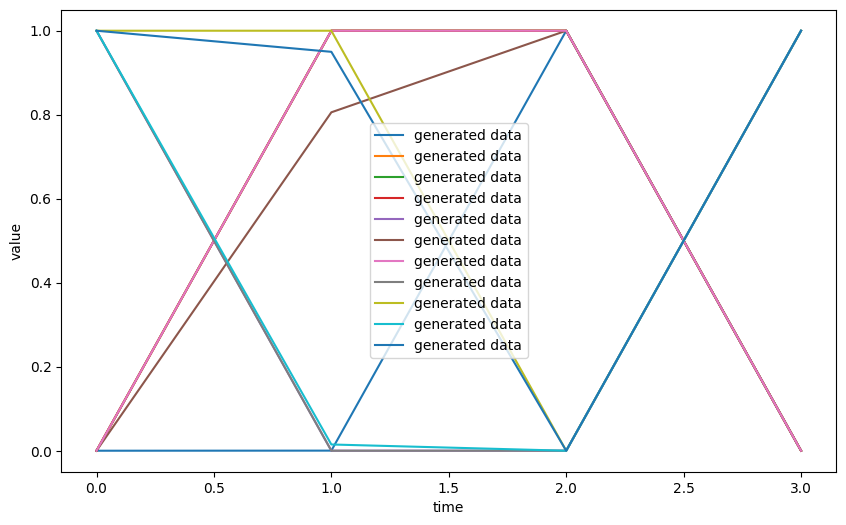

In [103]:
import matplotlib.pyplot as plt
generated_data = build_generator.predict(random_walk_noise)

plt.figure(figsize=(10,6))
plt.plot(generated_data[:4], label="generated data")
plt.xlabel("time")
plt.ylabel("value")
plt.legend()
plt.show()

In [104]:
print("original df shape", test_df_scaled.shape)
print("generated df shape", generated_data.shape)

print("Original dataframe summary statistics:")
print((test_df_scaled))

original df shape (500, 11)
generated df shape (16, 11)
Original dataframe summary statistics:
[[ 0.2237123   0.29397793  0.25929452 ... -0.405862   -0.77984636
  -0.92149223]
 [ 0.29501229  0.28371982  0.20642627 ...  1.18679634  0.24524123
   1.00876921]
 [ 0.23625582  0.29508812  0.23570042 ... -0.52543175 -1.31638078
  -0.88676647]
 ...
 [ 2.02909849  2.00721626  2.01377781 ... -0.94206247  0.02482551
  -0.15391671]
 [ 2.24783982  2.30519006  2.27768216 ... -0.69822973 -0.05020638
  -0.59533789]
 [ 2.36139166  2.33782952  2.32312265 ...  0.00758464  0.90863388
   0.55007998]]


In [105]:
print("Generated dataframe summary statistics:")
print(pd.DataFrame(generated_data))

Generated dataframe summary statistics:
              0             1             2             3             4   \
0   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
1   2.255752e-04  1.000000e+00  1.000000e+00  9.999892e-01  8.262848e-05   
2   1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
3   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
4   4.796212e-13  5.495973e-03  6.926983e-07  4.374552e-07  5.006527e-01   
5   1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
6   1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
7   1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
8   1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
9   1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
10  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
11  1.000000e+00  1.000000e+00  1.000000e+00  1.

In [106]:
generated_data_inverse = scaler.inverse_transform(generated_data)
generated_data_df = pd.DataFrame(generated_data_inverse)
generated_data_df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,332.344116,335.299957,329.451019,332.546204,75400640.0,441684.46875,332.389435,0.016398,0.017618,-0.001534,0.012362
1,332.354370,380.337494,375.225159,378.054718,57627696.0,576175.68750,377.817596,0.000592,0.017618,-0.009431,0.011715
2,377.785919,380.337494,375.225159,378.055237,57626228.0,608598.00000,377.817596,0.000592,0.008655,-0.009550,-0.000509
3,332.344116,335.299957,329.451019,332.546204,75400640.0,441684.46875,332.389435,0.016398,0.017618,-0.001534,0.012362
4,332.344116,335.547485,329.451050,332.546234,66525040.0,441685.15625,332.442657,0.016398,0.017618,-0.001534,0.012362


In [114]:
# Create alpaca object for testing

timeframe = TimeFrame(1, TimeFrameUnit.Day)
symbol = 'QQQ'
start = datetime.utcnow() - timedelta(days=3)
end=datetime.utcnow() - timedelta(days=1)
request = StockBarsRequest(symbol_or_symbols=symbol, start=start, end=end, timeframe=timeframe)

current_df = client.get_stock_bars(request).df.tz_convert('America/New_York', level=1)
current_df.head()

open    high     low   close      volume  \
symbol timestamp                                                               
QQQ    2024-02-22 00:00:00-05:00  434.49  439.12  433.71  438.07  53887751.0   
       2024-02-23 00:00:00-05:00  439.65  440.59  435.79  436.78  39818772.0   

                                  trade_count        vwap  
symbol timestamp                                           
QQQ    2024-02-22 00:00:00-05:00     465808.0  436.415054  
       2024-02-23 00:00:00-05:00     388092.0  437.910344

In [108]:
# # Define constants

# latent_dim = 100
# input_shape = bars_df.shape[1]
# output_shape = bars_df.shape[1]
# num_samples = 1000
# gaussian_noise = np.random.normal(0,1,size=(num_samples, latent_dim))
# random_walk_noise = np.cumsum(gaussian_noise,axis=0)

In [109]:
# # define model building functions

# def build_generator(num_layers,layer_size,activation,output_activation):
#     model = models.Sequential()
#     model.add(layers.Dense(layer_size, activation = activation, input_dim=num_layers))

#     for _ in range(num_layers-1):
#         model.add(layers.Dense(layer_size, activation = activation))

#     model.add(layers.Dense(output_shape,activation = output_activation))

#     pass

# # def build_discriminator(layers,layer_size,activation):

# def build_discriminator(num_layers,layer_size,activation):
#     model = models.Sequential()
#     model.add(layers.Dense(layer_size, activation = activation, input_dim = input_shape))

#     for _ in range(num_layers - 1):
#         model.add(layers.Dense(layer_size, activation = activation))

#     model.add(layers.Dense(1))

#     pass

In [110]:
# Normalize data set

scaler = StandardScaler()
bars_df_scaled = scaler.fit_transform(bars_df)


In [111]:
from sklearn.base import BaseEstimator

class GeneratorWrapper(BaseEstimator):
    def __init__(self, num_layers, layer_size, activation, output_activation):
        self.num_layers = num_layers
        self.layer_size = layer_size
        self.activation = activation
        self.output_activation = output_activation
        self.model = None

    def fit(self, X, y=None):
        # Build generator model
        self.model = build_generator(self.num_layers, self.layer_size, self.activation, self.output_activation)
        # Compile the model
        self.model.compile(loss='binary_crossentropy', optimizer='adam')
        # Fit the model
        self.model.fit(X, X, epochs=3, batch_size=64, verbose=0)  # Assuming autoencoder-like training
        return self

class DiscriminatorWrapper(BaseEstimator):
    def __init__(self, num_layers=2, layer_size=128, activation='relu'):
        self.num_layers = num_layers
        self.layer_size = layer_size
        self.activation = activation
        self.model = None

    def fit(self, X, y=None):
        # Build discriminator model
        self.model = build_discriminator(self.num_layers, self.layer_size, self.activation)
        # Compile the model
        self.model.compile(loss='binary_crossentropy', optimizer='adam')
        # Fit the model
        self.model.fit(X, y, epochs=3, batch_size=64, verbose=0)  # Assuming binary classification
        return self

In [112]:
# # Perform girdsearch for generator

# generator_search = GridSearchCV(estimator=build_generator, param_grid=generator_grid, cv = 3)
# generator_search.fit(random_walk_noise, bars_df_scaled)
# best_generator_params = generator_search.best_params_

# # get the best output layer activation from gridsearch

# output_activation = best_generator_params.pop("output_activation")

# # Build the generator with the best parameters
# generator = build_generator(latent_dim, output_shape, output_activation, **best_generator_params)

# # Perform grid search for discriminator
# discriminator_search = GridSearchCV(estimator=build_discriminator, param_grid=discriminator_grid, cv=3)
# discriminator_search.fit(random_walk_noise,bars_df_scaled)
# best_discriminator_params = discriminator_search.best_params_

# # Build the discriminator with the best parameters
# discriminator = build_discriminator(**best_discriminator_params)



In [113]:
# Create GridSearchCV instance for the generator
generator_search = GridSearchCV(estimator=GeneratorWrapper(), param_grid=generator_grid, cv=3)
generator_search.fit(random_walk_noise, bars_df_scaled)
best_generator_params = generator_search.best_params_

# Create GridSearchCV instance for the discriminator
discriminator_search = GridSearchCV(estimator=DiscriminatorWrapper(), param_grid=discriminator_grid, cv=3)
discriminator_search.fit(bars_df_scaled)
best_discriminator_params = discriminator_search.best_params_

print("Best parameters for the generator:", best_generator_params)
print("Best parameters for the discriminator:", best_discriminator_params)

TypeError: __init__() missing 4 required positional arguments: 'num_layers', 'layer_size', 'activation', and 'output_activation'